In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

# Download the data
from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, opt_tenors, swap_tenors, strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
dataset_split_type = 'temporal_split'
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                   seed = 0,
                                                                                   train_ratio=0.8,
                                                                                   type=dataset_split_type)
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

In [2]:
from src.utils.save_model_and_history import save_model_and_history

EPOCHS = 3000
BATCH_SIZE = 16
HIDDEN_LAYERS_NODES =  [128, 48]
LOSS_TYPE = 'mse'
BETA = '3e-4'   # weight of Kullback-Leibler (KL) loss when we calculate total loss as a sum of KL loss and reconstruction loss.
LATENT_SPACE_DIM = 3
ACTIVATION = 'leaky_relu'   # or 'relu'

SEEDS = list(range(10))

import numpy as np
diffs = np.zeros(tuple([len(SEEDS)]) + data_test.shape)
for seed in SEEDS:

    # Create the name of the model based on characteristics
    NAME = 'vae_van_' + ACTIVATION + '_' + dataset_split_type + '_' + str(LATENT_SPACE_DIM) + '_' 
    for i, nodes in enumerate(HIDDEN_LAYERS_NODES):
        NAME += str(nodes) + '_'
    NAME += str(EPOCHS) + 'ep_bat' + str(BATCH_SIZE) +'_' + BETA + '_seednum' + str(seed)
    print(NAME)

    # Create VAE and fit it
    from src.models.vae_vanilla import VaeVanilla
    vae = VaeVanilla(input_shape=data_norm_train.shape[1:],
                    hidden_layers_nodes=HIDDEN_LAYERS_NODES,
                    latent_space_dim=LATENT_SPACE_DIM,
                    loss_type=LOSS_TYPE,  
                    beta=float(BETA),
                    activation=ACTIVATION,
                    seed=seed)
    vae.compile(optimizer='adam')
    history = vae.fit(data_norm_train, 
                    epochs=EPOCHS, 
                    verbose=0,
                    batch_size=BATCH_SIZE,
                    validation_data=data_norm_test)
    
    
    save_model_and_history(vae, 
                           history, 
                           NAME, 
                           data_type='vol')

    predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
    diffs[seed] = abs(data_test - predictions)

vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum0



c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum1
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum2
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum3
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum4
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum5
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum6
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum7
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum8
vae_van_leaky_relu_temporal_split_3_128_48_3000ep_bat16_3e-4_seednum9


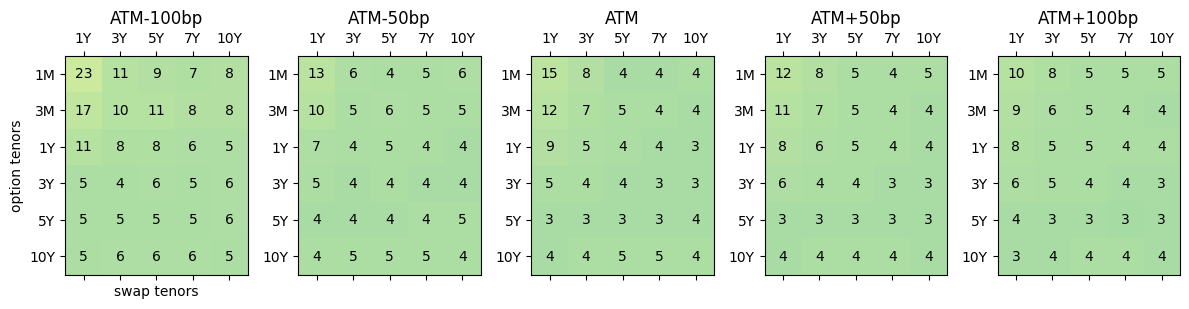

In [3]:
from references.global_parameters import MIN_VOL_ON_GRAPHS, MAX_VOL_ON_GRAPHS
import matplotlib.pyplot as plt

TICK_SIZE = 10

x_labels=swap_tenors
y_labels=opt_tenors
error_type = 'mse'

# Create grids for all strikes
fig = plt.figure(figsize=(12,3.3))

for strk_idx, strk in enumerate(strikes):

    # Create grid plot for certain strike     
    errors = np.zeros((len(y_labels), len(x_labels)))
    for i_y, y in enumerate(y_labels):      # option tenors
        for i_x, x in enumerate(x_labels):  # swap tenors
            # Calculate error for certain opt tenor and swap tenor
            diff = diffs[:, :, i_y, i_x, strk_idx]
            if error_type == 'mse':
                errors[i_y, i_x] = (diff**2).mean()**0.5
            elif error_type == 'abs_max':
                errors[i_y, i_x] = abs(diff).max()
            elif error_type == 'mean':
                errors[i_y, i_x] = diff.mean()
    
    ax = fig.add_subplot(1, len(strikes), strk_idx + 1)  # Create a 3D subplot    
    ax.set_title(strk)
    ax.matshow(errors, 
                cmap=plt.get_cmap('Spectral_r'), 
                vmin=MIN_VOL_ON_GRAPHS, 
                vmax=MAX_VOL_ON_GRAPHS)
    ax.set_xticks(ticks=range(len(x_labels)), labels=x_labels, size=TICK_SIZE)
    ax.set_yticks(ticks=range(len(y_labels)), labels=y_labels, size=TICK_SIZE)
    if strk_idx == 0:
        ax.set_xlabel('swap tenors')
        ax.set_ylabel('option tenors')

    for (x, y), value in np.ndenumerate(errors):
        ax.text(y, x, f"{value:.0f}", va="center", ha="center", color='black')
plt.tight_layout()

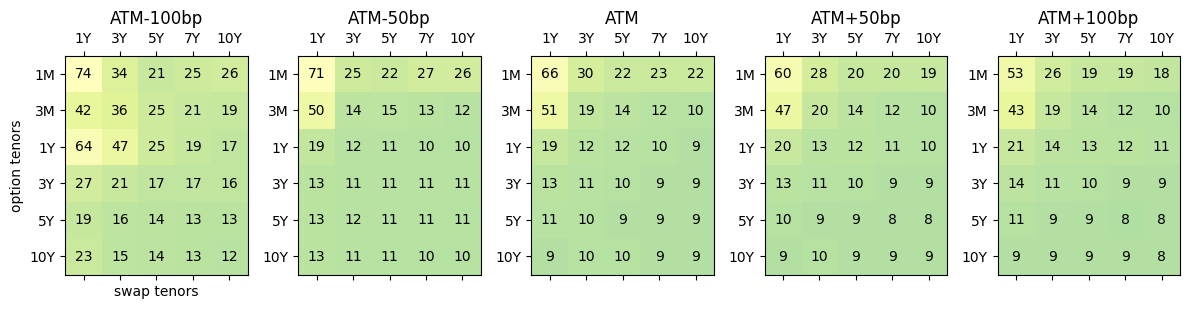

In [4]:
from references.global_parameters import MIN_VOL_ON_GRAPHS, MAX_VOL_ON_GRAPHS
import matplotlib.pyplot as plt

TICK_SIZE = 10

x_labels=swap_tenors
y_labels=opt_tenors
error_type = 'abs_max'

# Create grids for all strikes
fig = plt.figure(figsize=(12,3.3))

for strk_idx, strk in enumerate(strikes):

    # Create grid plot for certain strike     
    errors = np.zeros((len(y_labels), len(x_labels)))
    for i_y, y in enumerate(y_labels):      # option tenors
        for i_x, x in enumerate(x_labels):  # swap tenors
            # Calculate error for certain opt tenor and swap tenor
            diff = diffs[:, :, i_y, i_x, strk_idx]
            if error_type == 'mse':
                errors[i_y, i_x] = (diff**2).mean()**0.5
            elif error_type == 'abs_max':
                errors[i_y, i_x] = abs(diff).max(axis=1).mean(axis=0)
            elif error_type == 'mean':
                errors[i_y, i_x] = diff.mean()
    
    ax = fig.add_subplot(1, len(strikes), strk_idx + 1)  # Create a 3D subplot    
    ax.set_title(strk)
    ax.matshow(errors, 
                cmap=plt.get_cmap('Spectral_r'), 
                vmin=MIN_VOL_ON_GRAPHS, 
                vmax=MAX_VOL_ON_GRAPHS)
    ax.set_xticks(ticks=range(len(x_labels)), labels=x_labels, size=TICK_SIZE)
    ax.set_yticks(ticks=range(len(y_labels)), labels=y_labels, size=TICK_SIZE)
    if strk_idx == 0:
        ax.set_xlabel('swap tenors')
        ax.set_ylabel('option tenors')

    for (x, y), value in np.ndenumerate(errors):
        ax.text(y, x, f"{value:.0f}", va="center", ha="center", color='black')
plt.tight_layout()

Mean error 6.01
Max error 73.89


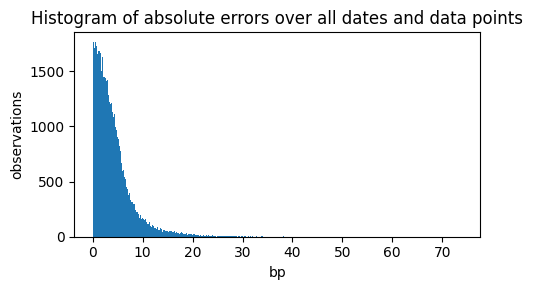

In [5]:
from src.visualization.vol.hist_errors import hist_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
hist_errors(predictions,
                 data_test,
                 bins=500)

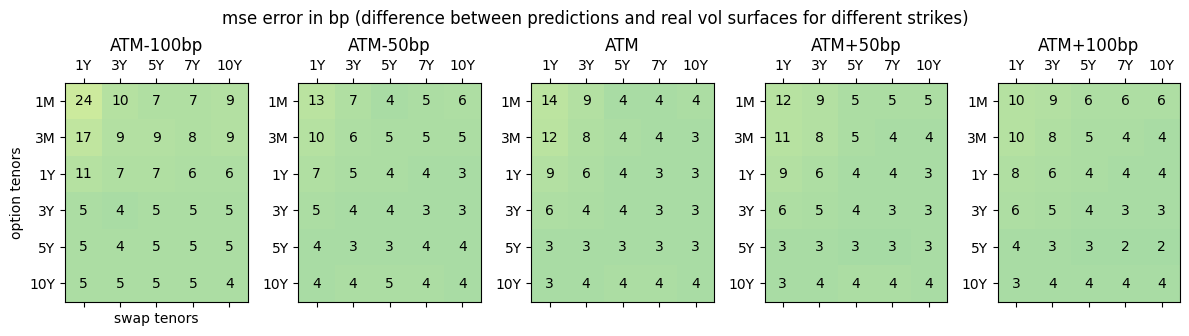

In [6]:
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
grids_vol_cube_errors(predictions,
                     data_test,
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mse'
                     )

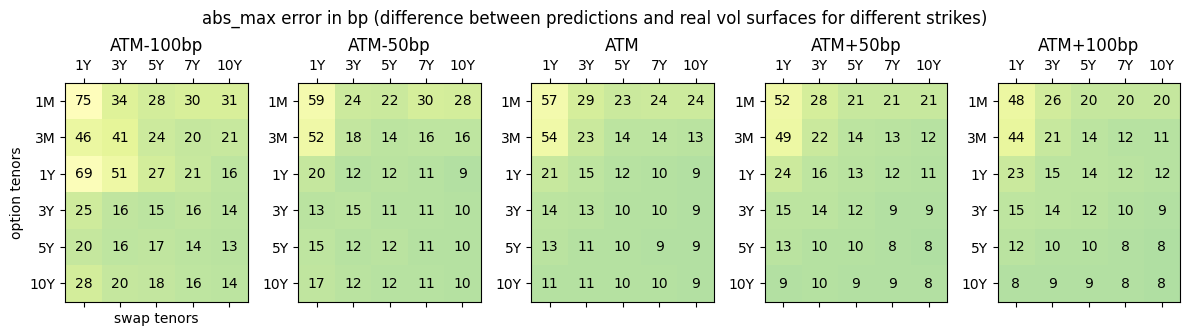

In [7]:
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
grids_vol_cube_errors(predictions,
                     data_test,
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='abs_max'
                     )